# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering

In [2]:
M = load("model_custom.jld");

In [3]:
#model = Model(M["n"], M["d"], M["o"], M["m"])
model0 = Model(M["n"], M["d"], M["o"], M["m0"])
dm = vec(M["dm"]);

In [4]:
vmin = ones(Float32,model0.n) .* 1.5f0
vmax = ones(Float32,model0.n) .* 3.0f0;
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
block = segy_read("model_custom_low_f.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=4763124, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geouser/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.004f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [13]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [14]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [15]:
# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end

FWI iteration no: 1; function value: 61043.07
(α, misfit) = 

Building forward operator
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.02 s
Building adjoint born operator
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 

(0.1f0, 100971.328125)


Building forward operator
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.041390269922676075, 23790.8828125)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


2; function value: 23885.797


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 7381.31494140625)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


3; function value: 8068.2866


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 957815.1875)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.010000000149011612, 10073.328125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.004091339317163616, 5694.87890625)
FWI iteration no: 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


4; function value: 5406.114


Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 31029.37890625)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.03459464172402602, 3378.726318359375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 5; function value: 3641.873
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 70641.8828125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.018032515663869916, 1826.1734619140625)
FWI iteration no: 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s


6; function value: 1826.9579


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 179243.328125)
(α, misfit) = 

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010000000149011612, 1384.58154296875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


FWI iteration no: 7; function value: 1544.7917
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 32489.55859375)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.024677410058431864, 2142.411376953125)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.010766735853472773, 918.6958618164062)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 8; function value: 1059.175
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.0074386875e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 9598.7216796875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 842.0501708984375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 9; function value: 1062.5032
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.

(0.1f0, 61931.41015625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1122.665283203125)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0046324776698929955, 829.33837890625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 10; function value: 899.04205
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 13938.4306640625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.0244476886328764, 1310.127197265625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.010075654794612015, 781.0872192382812)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 11; function value: 842.4202
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.13626475e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 10432.7998046875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 616.6719360351562)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 12; function value: 769.01135
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 116114.4453125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 1516.9986572265625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.002738957177324461, 590.1259155273438)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 13; function value: 674.7529
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 44132.06640625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 838.69189453125)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(0.004104830717277694, 561.84814453125)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s


FWI iteration no: 14; function value: 643.5443
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.0377411875e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 9672.5107421875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 493.1485900878906)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


FWI iteration no: 15; function value: 666.63794
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 29614.421875)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.0110190593756411, 783.0293579101562)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.004764118299690554, 580.3794555664062)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s


FWI iteration no: 16; function value: 584.7747
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.1079355e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 10904.65625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 425.1346740722656)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 17; function value: 491.22858
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 8237.865234375)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.026513818329931566, 894.1636962890625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.03 s


(0.010407917693481445, 459.0422668457031)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 18; function value: 648.9617
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.11900925e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 11060.60546875)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 445.0066223144531)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 19; function value: 527.3247
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 101982.5546875)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1229.6605224609375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0027422106078686423, 435.1463317871094)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 20; function value: 605.57416
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.145866625e6)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 12019.3359375)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 402.3753967285156)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 21; function value: 427.28418
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 2420.55078125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.04064129693887498, 646.3101806640625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.016817993475206967, 380.2237243652344)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 22; function value: 527.746
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.070414e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 9995.34765625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 324.46649169921875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


FWI iteration no: 23; function value: 407.24268
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 86301.625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1027.7615966796875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0028270805383780314, 316.9625549316406)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s


FWI iteration no: 24; function value: 530.1197
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.12584175e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 11992.6533203125)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 329.3748779296875)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


FWI iteration no: 25; function value: 379.6668
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 8572.6923828125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.02636620506240994, 793.8446044921875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.010377033113472158, 343.18377685546875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 26; function value: 452.61932
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.03 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.06913875e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 9697.7119140625)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 277.39385986328125)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 27; function value: 363.85092
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 105955.4453125)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.010000000149011612, 1123.3128662109375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


(0.0026559227603948983, 270.26080322265625)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


FWI iteration no: 28; function value: 428.00146
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.0255780625e6)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 10324.42578125)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(0.0010000000149011613, 264.1204833984375)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


FWI iteration no: 29; function value: 359.73593
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 9203.3603515625)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


(α, misfit) = (0.024736918327144326, 744.2836303710938)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.00973067596275246, 312.7972717285156)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.02 s


FWI iteration no: 30; function value: 431.9097
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `gradient` ran in 0.

(0.1f0, 1.16548525e6)


Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(α, misfit) = (0.010000000149011612, 10861.66796875)
(α, misfit) = 

Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s


(0.0010000000149011613, 261.5318908691406)


Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s


In [38]:
reshape(m0_values[:, 29], (101,101))

101×101 Matrix{Float64}:
 0.441864  0.444444  0.444444  0.442615  …  0.111366  0.111296  0.111243
 0.444444  0.444444  0.444444  0.442906     0.1114    0.111321  0.111261
 0.444444  0.444444  0.444294  0.443804     0.111435  0.111347  0.11128
 0.44435   0.444276  0.444109  0.443882     0.111471  0.111374  0.1113
 0.444276  0.444326  0.444313  0.444216     0.111508  0.111401  0.11132
 0.444444  0.444444  0.444444  0.444444  …  0.111546  0.111429  0.11134
 0.444444  0.444444  0.444444  0.444444     0.111584  0.111457  0.111361
 0.444444  0.444444  0.444444  0.444444     0.111622  0.111485  0.111381
 0.444444  0.444444  0.444444  0.444444     0.111661  0.111514  0.111402
 0.444444  0.444444  0.444444  0.444444     0.111699  0.111543  0.111423
 ⋮                                       ⋱                      ⋮
 0.444444  0.444444  0.444444  0.444444     0.111673  0.111522  0.111408
 0.444444  0.444444  0.444444  0.444444     0.111634  0.111493  0.111387
 0.444444  0.444444  0.444444  0.44444

In [39]:
fwi = sqrt.(1f0./adjoint(reshape(m0_values[:, 29], (101,101))));
v0 = sqrt.(1f0./M["m0"])';
v = sqrt.(1f0./M["m"])';

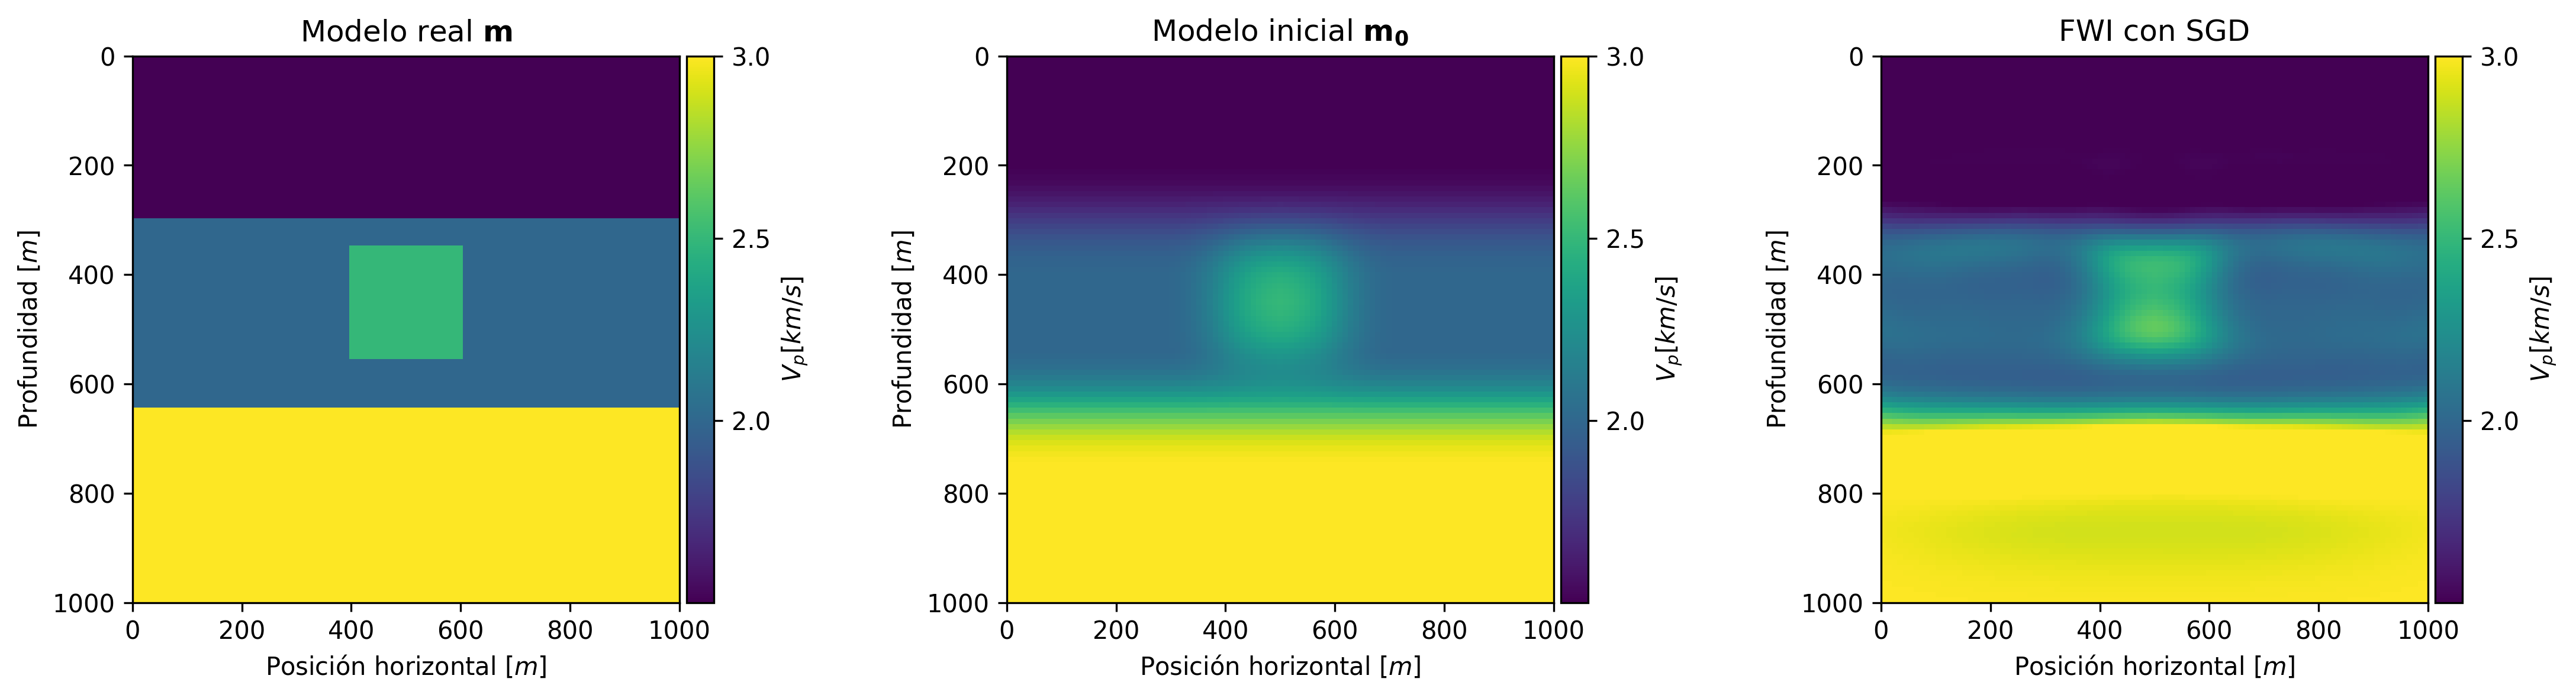

In [40]:
fig=figure(figsize=(18,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=3.0)
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI con SGD")
display(fig)

In [41]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.01610154849900713
El error cuadrático medio de FWI es: 

0.010883275574486557


In [42]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 2.9251756195527445
Porcentaje de error (FWI): 2.2028565432879903


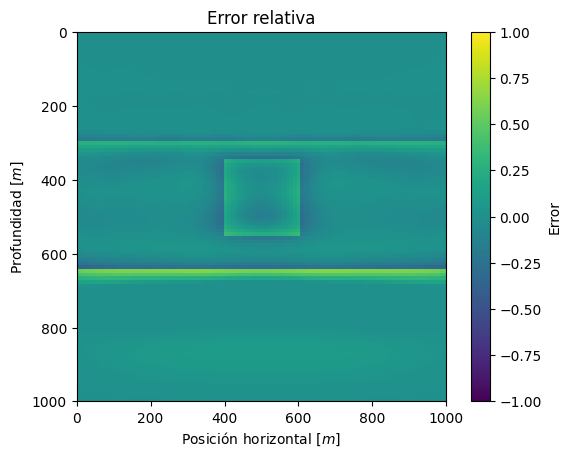

In [27]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-1, vmax=1)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

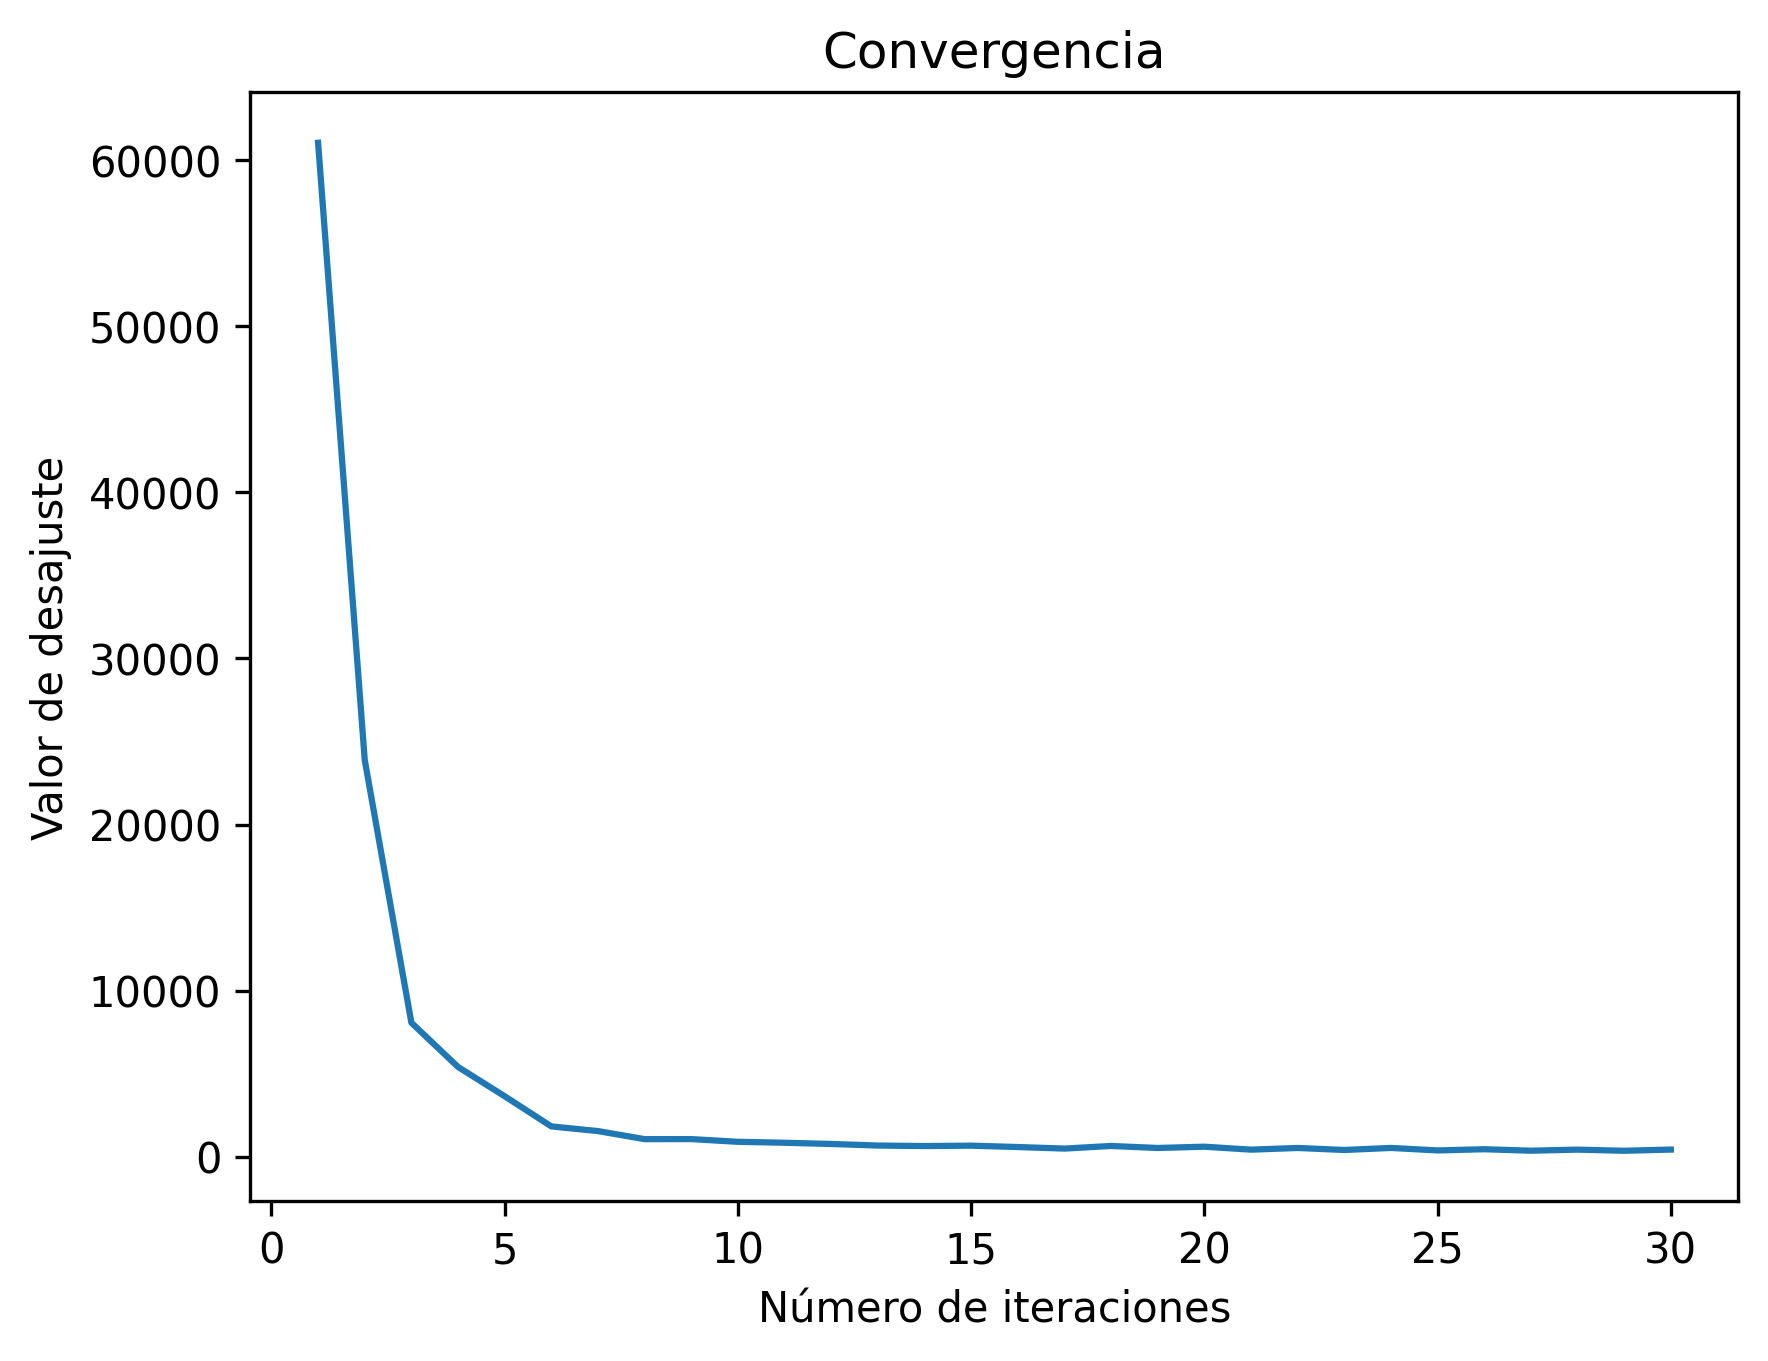

In [45]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [46]:
save("model_custom_fwi_result_low_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)